In [89]:
#setup
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gensim
from unidecode import unidecode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)

In [90]:
from main import nlp_pipeline_result

In [117]:
# data = nlp_pipeline_result(
#     parser_parameters={
#         "remove_hashtag_word": True,
#         "replace_politics": True,
#         "replace_parties": True,
#     },
#     nlp_parameters={
#         "disable_parser": True,
#         "disable_ner": True
#     }
# )
# data['n_lemmas'] = data['Lemmas'].str.split().str.len()
# 
# data.to_csv('data/data.csv', index = False)

In [92]:
data = pd.read_csv('data/data.csv')


In [93]:


train = data.sample(frac = 0.8, random_state = 420)
test = data.drop(train.index)

print("Len data: ", len(data))
print("Len train: ", len(train))
print("Len test: ", len(test))


data = train
data['Lemmas'] = data['Lemmas'].str.lower()
data['Lemmas'] = data['Lemmas'].apply(lambda x: unidecode(str(x)))
# quitamos mayusculas y acentos
# para quitar palabras duplicadas
#ññññññ

Len data:  14791
Len train:  11833
Len test:  2958


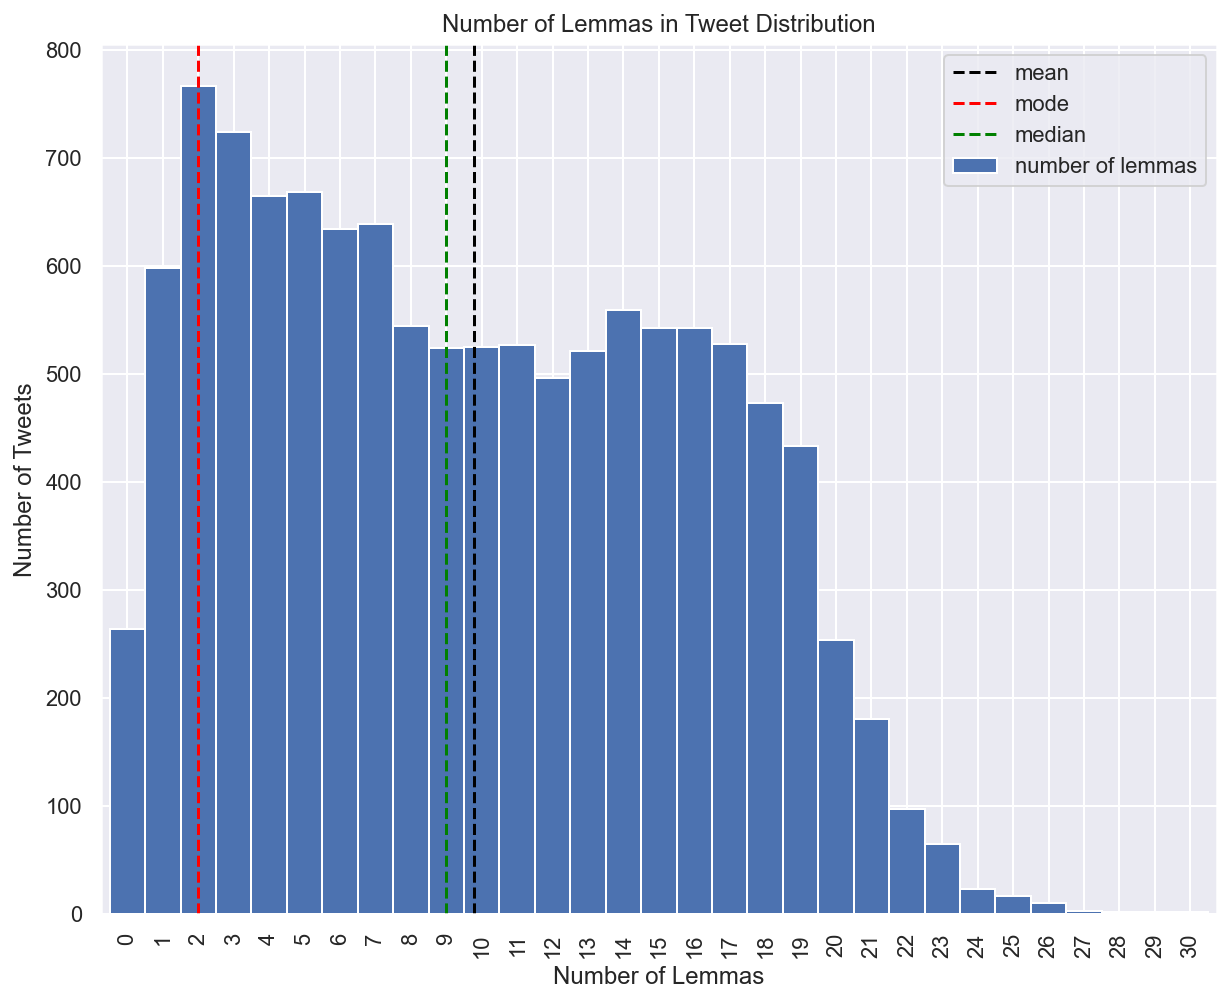

In [94]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar",width=1,label='number of lemmas')
plt.axvline(x = data['n_lemmas'].mean(),label='mean',color = 'black',linestyle = '--')
plt.axvline(x = data['n_lemmas'].mode()[0],label='mode',color = 'red',linestyle = '--')
plt.axvline(x = data['n_lemmas'].median(),label='median',color = 'green',linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [95]:
data = data[data['n_lemmas']>=3]
print('Number of Tweets in Dataframe after removing short tweets:', len(data))

Number of Tweets in Dataframe after removing short tweets: 10204


In [96]:
tweets_corpus = data["Lemmas"].tolist()
# tweets_corpus = list(set(tweets_corpus))
tweets_corpus = [el.split() for el in tweets_corpus]

# display(tweets_corpus)

In [97]:
from gensim.corpora import Dictionary

token_dic = Dictionary(tweets_corpus)


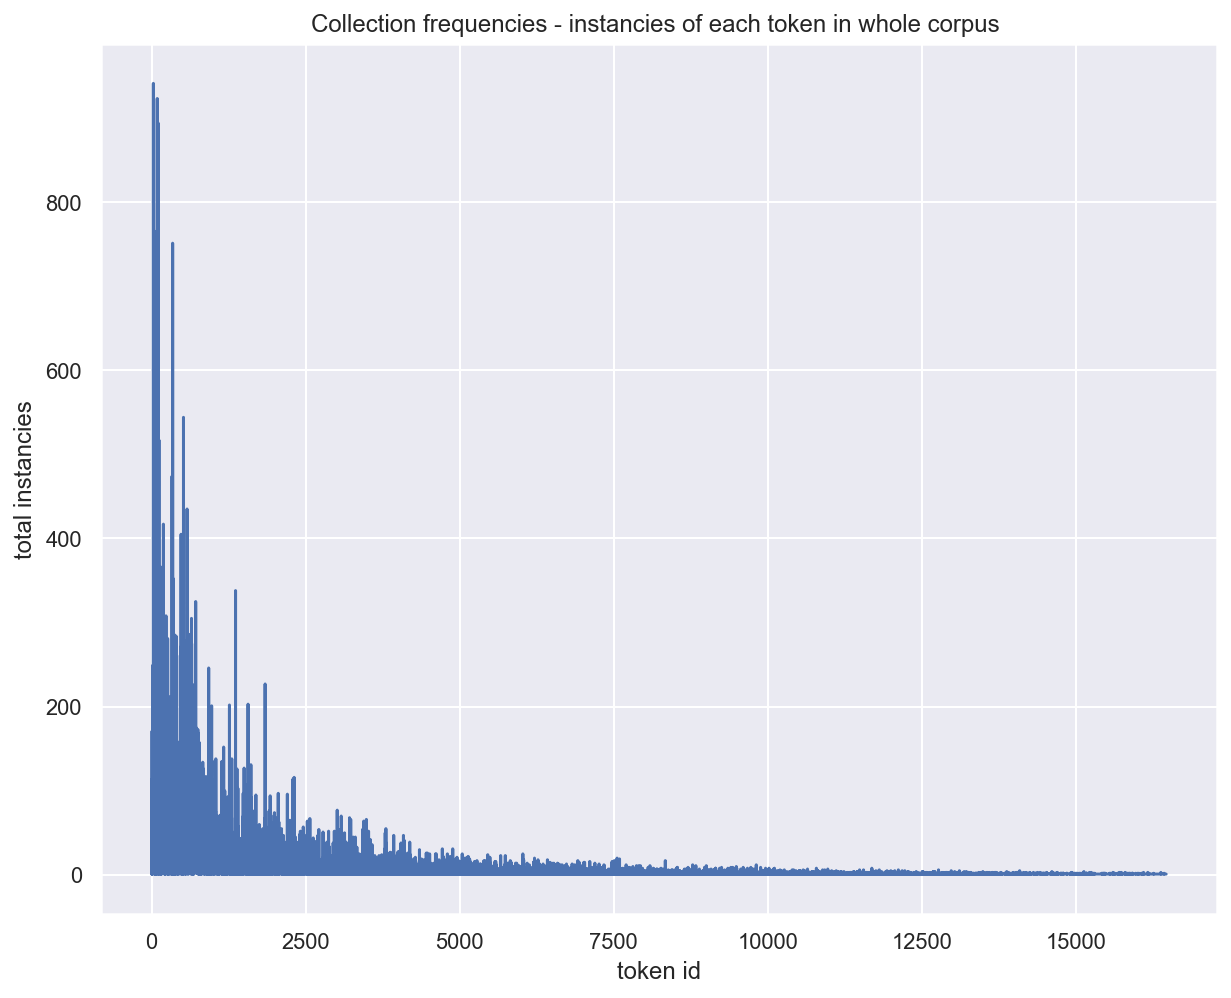

Max of occurances per topic:  941
Mean of occurances per topic:  6.903503977652274


In [98]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.

collfreq = token_dic.cfs.items()
collfreq = sorted(collfreq) 
x, y = zip(*collfreq) 
plt.plot(x, y)
plt.title('Collection frequencies - instancies of each token in whole corpus ')
plt.xlabel('token id')
plt.ylabel('total instancies')
plt.show()



# MEAN

count = 0
_sum = 0
for key in token_dic.cfs:
    count += 1
    _sum += token_dic.cfs[key]

instances_mean = _sum/count



#MAX

instances_max = max(token_dic.cfs.values())





print("Max of occurances per topic: ",instances_max )
print("Mean of occurances per topic: ",instances_mean )






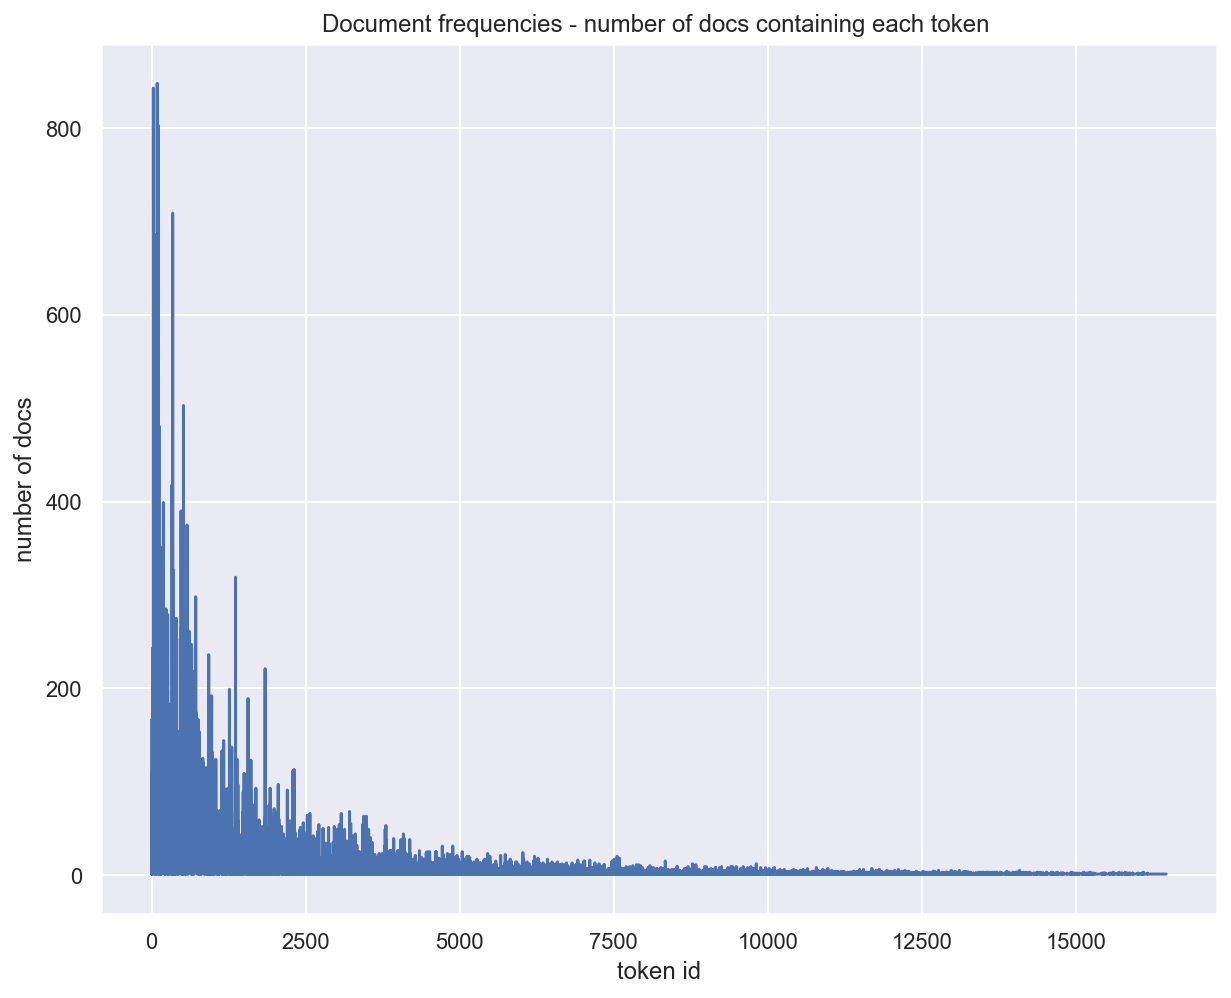

Max of docs in which a token appears:  848
Mean of docs in which token appears:  6.653670978320277


In [99]:
# Document frequencies: token_id -> how many documents contain this token


docfreq = token_dic.dfs.items()
docfreq = sorted(docfreq) 
j, k = zip(*docfreq) 
plt.plot(j, k)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')
plt.show()



# MEAN

count = 0
_sum = 0
for key in token_dic.dfs:
    count += 1
    _sum += token_dic.dfs[key]

docs_mean = _sum/count



#MAX

docs_max = max(token_dic.dfs.values())





print("Max of docs in which a token appears: ",docs_max )
print("Mean of docs in which token appears: ",docs_mean )



In [100]:
#FILTER TOKEN DICTIONARY




no_below_list = [1,2,3,4,5,6,7,8,9,10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [.5, .4, .3, .2, .05, .04, .03, .02, .005, .004, .003, .002, .0005, .0004, 0.0003, .0002] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

prev_dic = copy.copy(token_dic)
prev_tokens = len(token_dic)


# print('The dictionary contained', prev_tokens, 'terms')

# for i in no_below_list:
    
#     for j in no_above_list:
        
#         token_dic = Dictionary(tweets_corpus)
        
#         token_dic.filter_extremes(no_below=i,no_above=j)
        
#         n_tokens = len(token_dic)
        
#         print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)



#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY



In [101]:
token_dic.filter_extremes(no_below=3,no_above=1)
# no filtramos con no_above porque los tweets son documentos con muy pocas palabras 

# for n in range(500):
#     print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY

print('The dictionary contains', len(token_dic), 'terms')


The dictionary contains 5164 terms


In [102]:

# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]

# tweets_corpus_bow

In [103]:
from gensim.models.wrappers import LdaMallet
import os

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

num_topics = 10

ldamallet = LdaMallet(
    mallet_path,
    corpus=tweets_corpus_bow,
    num_topics=num_topics,
    id2word=token_dic,
    alpha=5,
    iterations=100
)

IndexError: index 10 is out of bounds for axis 0 with size 10

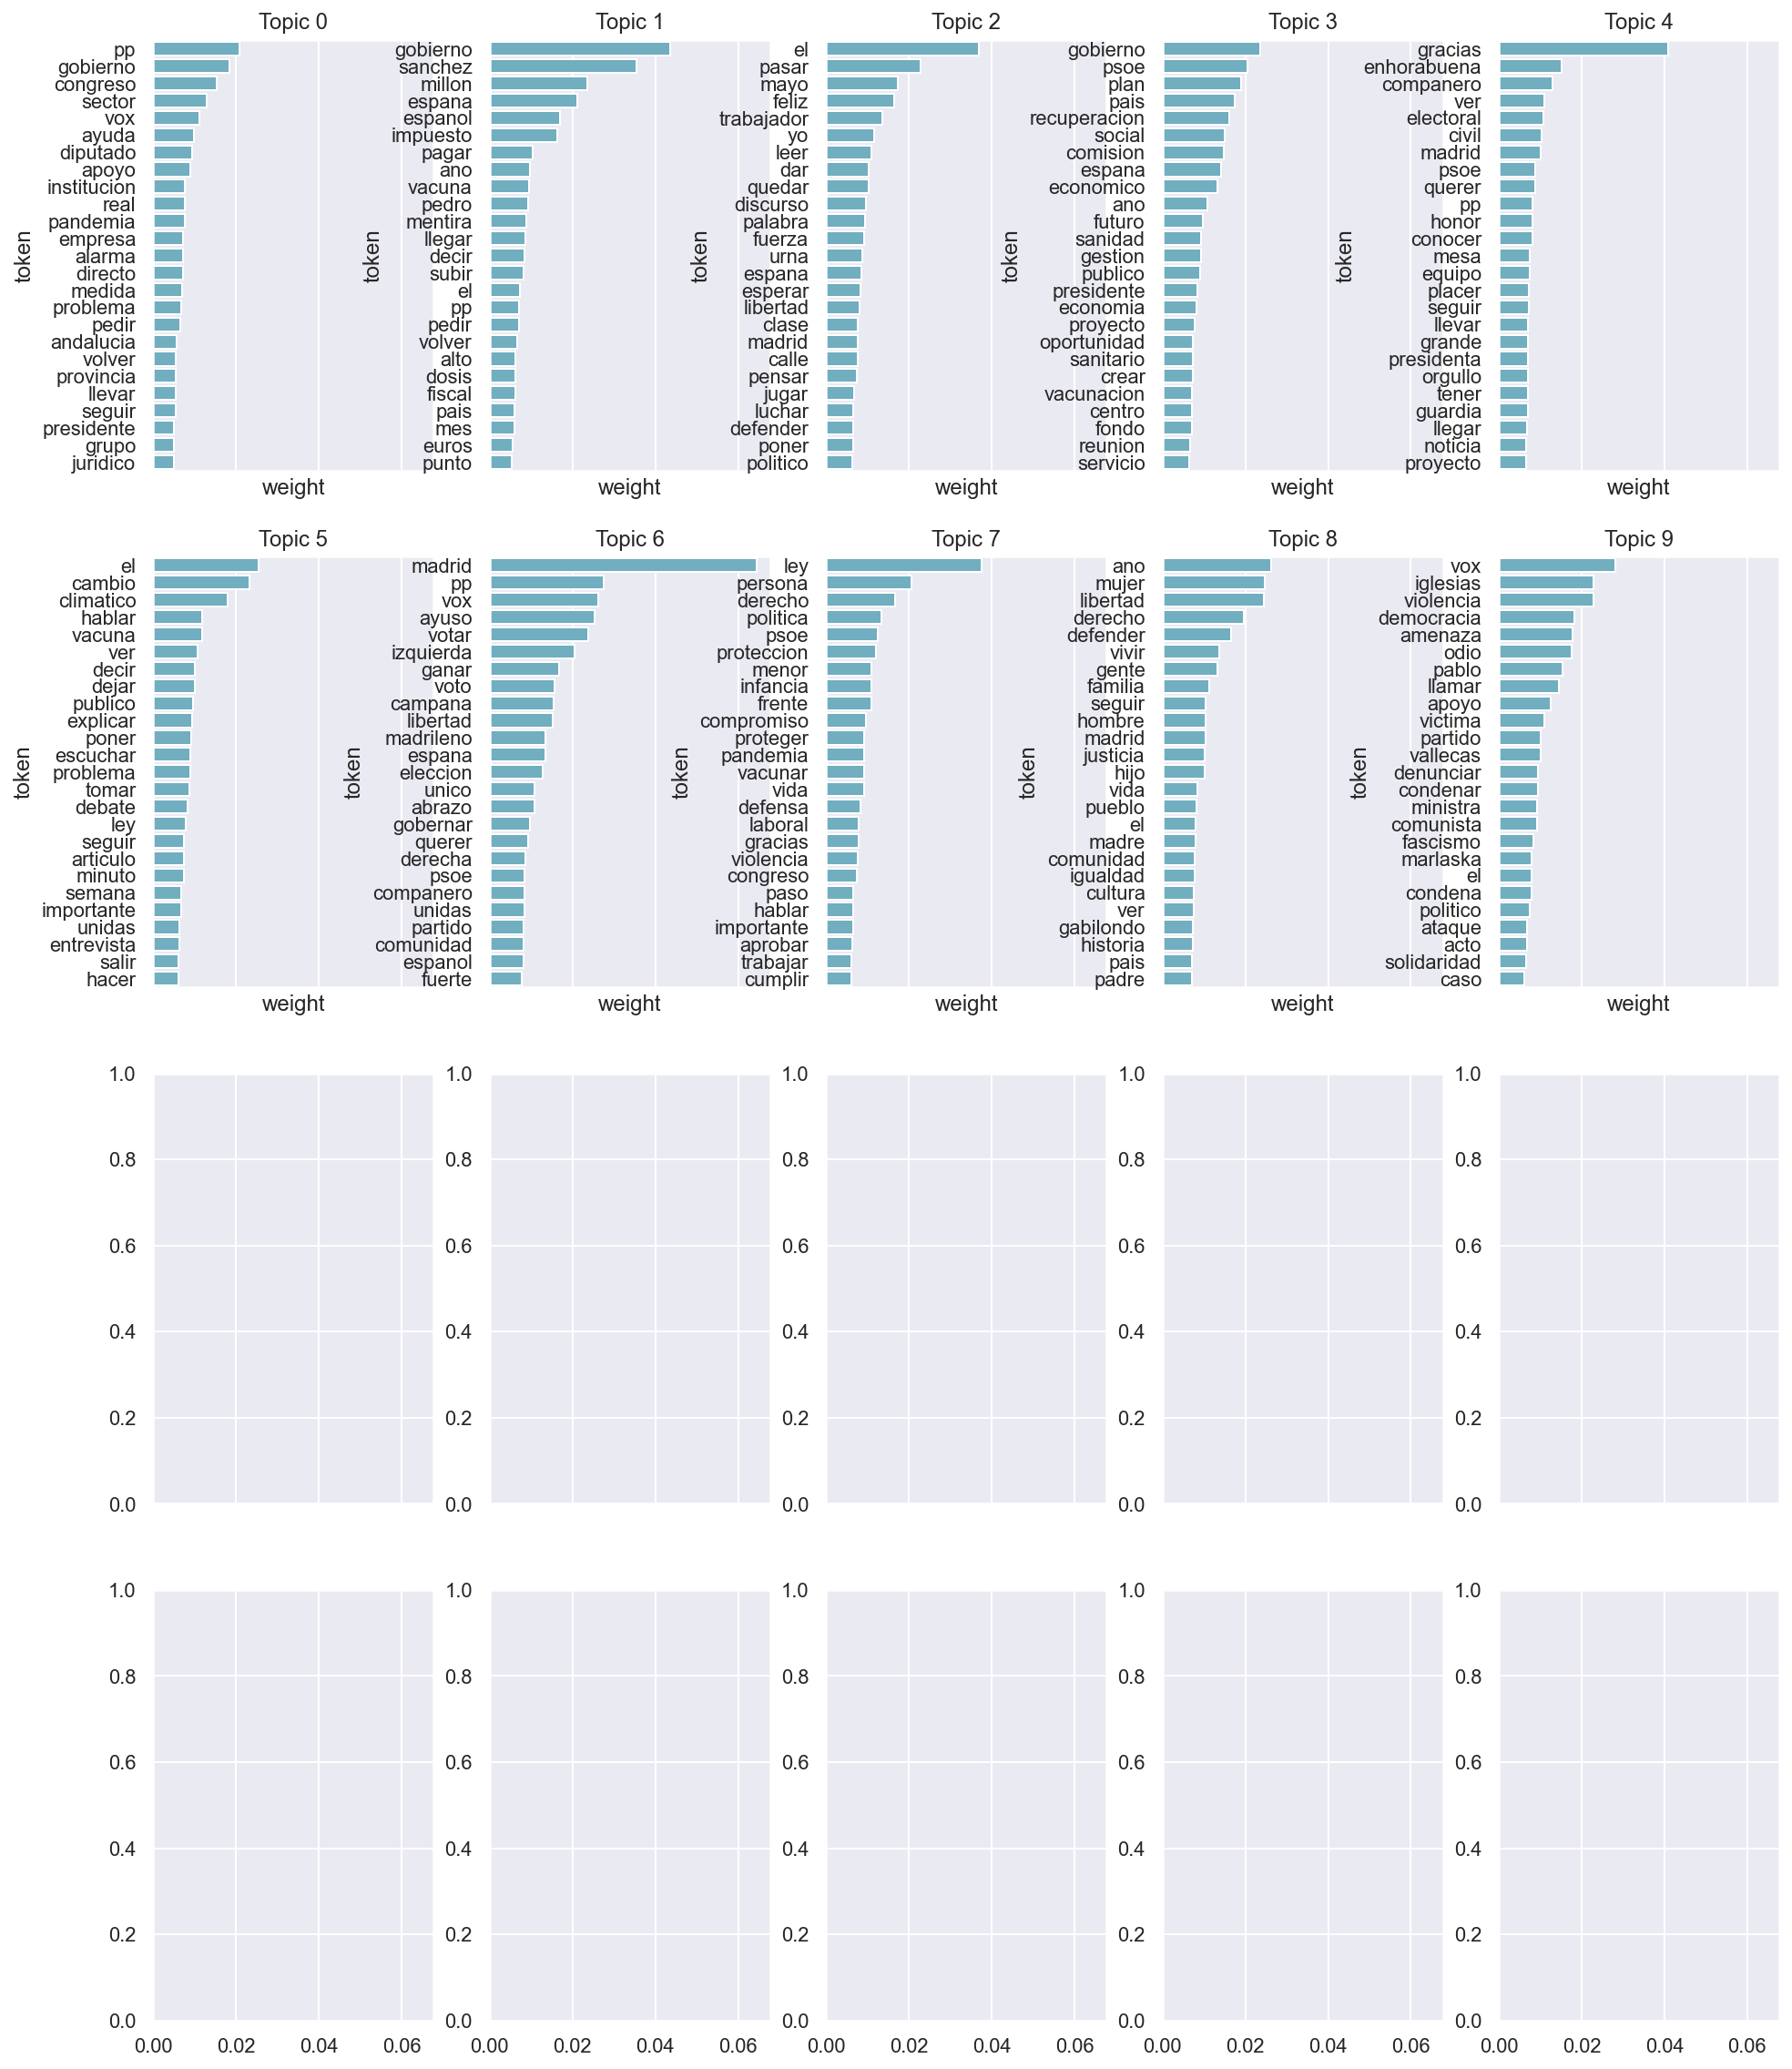

In [104]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)


for i in range(4):
    for j in range(5):
        df = pd.DataFrame(ldamallet.show_topic(j + 5*(i%5), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title('Topic ' + str(j + 5*(i%5)))

    
plt.show()

In [105]:
specific_stw = ['el',
'ano',
'vivir',
'hacer',
'plan',
'sector',
'salir',
'gestion',
'resto',
'ir',
'yo',
'ley',
'gobierno',
'serio',
'nacional',
'acto',
'minuto',
'explicar',
'estar',
'poner',
'discurso',
'pedir',
'volver',
'alto',
'punto',
'pasar',
'pais',
'dar',
'quedar',
'hablar',
'decir',
'dejar',
'ver',
'paso',
'importante',
'aprobar',
'gente']

specific_stw = list(set([el.lower() for el in specific_stw]))

In [107]:
def remove_stpwrd(string, specific_stw_eliminate):
  splitted = string.split()
  resultwords  = [word for word in splitted  if word.lower() not in specific_stw_eliminate]
  result = ' '.join(resultwords)
  return result

In [115]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(x, specific_stw))
data['n_lemmas'] =  data['Lemmas'].str.split().str.len()


9821                               encontrar avisame favor
7882     automatico lenguaje inclusivo pobre nadia calv...
559      tener restaurante congreso barato menu edelwei...
2943     elecciones autonomico comunidad madrid interve...
958                         obsesion noche senor gabilondo
                               ...                        
6465     abascal ensenar adoquin levantar mano victima ...
14712    personascon vidacon dolorcon soledad dales com...
11145                           psoe seguir luchar derecho
8695     mirar proporcion plantilla taller superar muje...
9893     visitar fabrica canario empresa emprendedor el...
Name: Lemmas, Length: 10204, dtype: object

In [ ]:
#<SOL>
data['clean_lemmas'] = data['lemmas'].apply(remove_stpwrd, specific_stw)

data['nlemmas'] =  data['clean_lemmas'].str.split().str.len()
#</SOL>
NSF_df = NSF_df[NSF_df['nlemmas']>=100]
print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

In [ ]:
# print(list(ldamallet.load_document_topics()))
# print(len(list(ldamallet.load_document_topics())))


rec = []
for topic in ldamallet.load_document_topics():
    rec.append([value[1] for value in topic])
       
df = pd.DataFrame(rec)

print(len(df), len(data))


df['Likes'] = data.sort_index()["Likes"].to_list()
df['Retweets'] = data.sort_index()["Retweets"].to_list()
df["Party"] = data.sort_index()["Party"].to_list()
df